In [329]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
from sklearn.cross_validation import cross_val_score
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [304]:
#=train[train.isnull().any(axis=1)]

#Look at missing data by column.
def checkmissing(x):
    for a in x.columns:
        print x[a].isnull().value_counts()
        print "*****************************"

In [16]:
train = pd.read_csv('train_users_2.csv')
print train.columns
train.head()

Index([u'id', u'date_account_created', u'timestamp_first_active',
       u'date_first_booking', u'gender', u'age', u'signup_method',
       u'signup_flow', u'language', u'affiliate_channel',
       u'affiliate_provider', u'first_affiliate_tracked', u'signup_app',
       u'first_device_type', u'first_browser', u'country_destination'],
      dtype='object')


,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [10]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


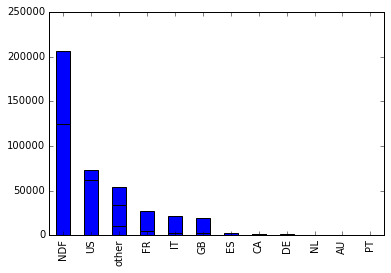

In [11]:
# train['signup_method'].value_counts().plot(kind='bar')

#train['gender'].value_counts().plot(kind='bar')

#train['language'].value_counts().plot(kind='bar')

#train['first_device_type'].value_counts().plot(kind='bar')

#train['first_browser'].value_counts().plot(kind='bar')
train['country_destination'].value_counts().plot(kind='bar')

In [ ]:
#Feature Engineering:
#get the month, day from the date columns.
#get time lapses.

In [17]:
countrytrain = train['country_destination']
train.drop('country_destination',axis=1,inplace=True)
#roll up the countries other than NDF and US, into other.
mod_country=countrytrain.apply(lambda x : 'special' if (x!='US'and 'NDF') else x)

In [6]:
def prepro(tbl):
    
    print "Turn the na's to dummy code column ********************************"
    tbl['null_booking']= tbl['date_first_booking'].isnull()
    
#Timestamps get the same time as date_account created if they are NA
    new_date_first_booking=tbl.apply(lambda x :x['date_account_created'] if x['null_booking'] else x['date_first_booking'],axis=1)
    
# age columns changed into age ranges.  
    age_range=pd.cut(tbl['age'],[0,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94,99,5000], include_lowest=True)
    tbl.drop(['date_first_booking','age'],axis=1,inplace=True)
    
    
    

#get month,day,quarter from time columns
    print "get month,day,quarter from the time columns ********************************"

    tbl['date_account_created_month']=pd.to_datetime(tbl['date_account_created']).dt.month
    tbl['date_account_created_day']=pd.to_datetime(tbl['date_account_created']).dt.dayofweek
    tbl['date_account_created_quarter']=pd.to_datetime(tbl['date_account_created']).dt.quarter

    tbl['date_first_booking_month']=pd.to_datetime(new_date_first_booking).dt.month
    tbl['date_first_booking_day']=pd.to_datetime(new_date_first_booking).dt.dayofweek
    tbl['date_first_booking_quarter']=pd.to_datetime(new_date_first_booking).dt.quarter


# Get time lapses
    print "get time lapses of columns ********************************"
    tfa=pd.to_datetime(train['timestamp_first_active'],format='%Y%m%d%H%M%S')
    tbl['timestamp_day'] =tfa.dt.dayofweek
    tbl['timestamp_month'] =tfa.dt.month
    tbl['timestamp_quarter'] =tfa.dt.quarter

    dac=pd.to_timedelta(pd.to_datetime(train['date_account_created']))
    dfb=pd.to_timedelta(pd.to_datetime(new_date_first_booking))
    tfa=pd.to_timedelta(tfa)

    tbl['time_created_booking']=(dac-dfb).astype('timedelta64[s]')
    tbl['time_active_booking']=(tfa-dfb).astype('timedelta64[s]')
    tbl['time_booking_created']=(dac-tfa).astype('timedelta64[s]')


# dummy code the categorical variables
    print "Dummy code categorical variables ********************************"
    tbl_mod=pd.get_dummies(tbl['gender'],prefix='gender')
    for a in tbl.columns[4:-3]:
        tbl_mod=tbl_mod.join(pd.get_dummies(train[a],prefix=a))

    tbl_mod=tbl_mod.join(pd.get_dummies(age_range,prefix='age_range',dummy_na=True))

# Scale the last three columns
    print "center scale the time columns ********************************"
    tbl_mod[tbl.columns[-3]]=scale(tbl[tbl.columns[-3]])
    tbl_mod[tbl.columns[-2]]=scale(tbl[tbl.columns[-2]])
    tbl_mod[tbl.columns[-1]]=scale(tbl[tbl.columns[-1]])
    return tbl_mod

In [18]:
train_mod=prepro(train)

Turn the na's to dummy code column ********************************
get month,day,quarter from the time columns ********************************
get time lapses of columns ********************************
Dummy code categorical variables ********************************
center scale the time columns ********************************


In [21]:
#train classifiers on the training data without sessions statistics

y = countrytrain
#gbc = GradientBoostingClassifier()
#abc = AdaBoostClassifier()
etc = ExtraTreesClassifier(n_estimators=10,criterion='entropy',class_weight='balanced')
gnb = GaussianNB()
svc = LinearSVC()
rfc = RandomForestClassifier(n_estimators=10,criterion='entropy',class_weight='balanced')
lr = LogisticRegression(class_weight='balanced')

bag =[etc,rfc,lr,gnb,svc]
for a in bag:
    print a
    print cross_val_score(a,train_mod,y).mean()
    #print cross_val_score(a,train_mod,y,scoring ='average_precision').mean()
    #print cross_val_score(a,train_mod,y,scoring='roc_auc').mean()
    a.fit(train_mod,y)
    print "********************************"
    

ExtraTreesClassifier(bootstrap=False, class_weight='balanced',
           criterion='entropy', max_depth=None, max_features='auto',
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
0.856112066299
********************************
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='entropy', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.865781776221
********************************
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_s

For a first pass, the cross validations scores on the classifiers look good. Naive Bayes is a
bit nutty. I suspect if we narrow down the features, it will behave better. Here are some ideas for more complicated models.

# Some users have sessions data. Get the statistics of each user in the session, merge the sessions statistics with the training data.

In [22]:
sessions = pd.read_csv('sessions.csv')
print sessions.shape
sessions.head()

(10567737, 6)


,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435
